<a href="https://colab.research.google.com/github/aivrm/ai/blob/main/GD_4_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%96%B4%EB%94%94%EA%B9%8C%EC%A7%80_%EC%9A%B0%EB%A0%A4%EB%B3%BC%EA%B9%8C(20).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [ ]:
print(np.__version__)

1.23.1


In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
print(keras.__version__)

2.6.0


In [ ]:
print(tfds.__version__)

4.7.0+nightly


---
#### 데이터셋 로딩

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True, # with_info 없으면 Error 발생
    with_info=True,     # 부가정보도 출력됨.
)

In [ ]:
ds_info.features["label"].names[:10]

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound']

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [ ]:
# 기본 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
# Augumentaion 함수
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,    # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# make random augment function
def augment2(image,label):
    # [[YOUR CODE]]
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

---
### stanford_dogs 데이터셋 다시 로딩
tensorflow_datasets.load

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True, # a 2-tuple structure (input, label)
    shuffle_files=True,
    with_info=True,
)

In [ ]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [ ]:
type(num_classes)

int

---
### ImageNet 으로 PreTrained 된 ResNet_50 모델을 2개 만든다.
* no_aug_resnet50
* aug_resnet50

In [ ]:
# (model) no_aug_resnet50
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# (model) aug_resnet50
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

---
### Augmentation

In [ ]:
# with_aug 어디가 True인지 볼 것.
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)  # Augmentation (with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)         # Augmentation (with_aug=True)

In [ ]:
ds_train_no_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
ds_train_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
ds_test

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

### Train
* ds_train_no_aug → no_aug_resnet50 → history_resnet50_no_aug
* ds_train_aug    → aug_resnet50    → history_resnet50_aug

In [ ]:
EPOCH = 20   # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [ ]:
no_aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_resnet50_no_aug = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 193s 238ms/step - loss: 2.2188 - accuracy: 0.4462 - val_loss: 3.6162 - val_accuracy: 0.1798
Epoch 2/20
750/750 [==============================] - 179s 238ms/step - loss: 0.8082 - accuracy: 0.7720 - val_loss: 1.2452 - val_accuracy: 0.6393
Epoch 3/20
750/750 [==============================] - 178s 238ms/step - loss: 0.3130 - accuracy: 0.9230 - val_loss: 1.0371 - val_accuracy: 0.7034
Epoch 4/20
750/750 [==============================] - 179s 239ms/step - loss: 0.1225 - accuracy: 0.9812 - val_loss: 0.9693 - val_accuracy: 0.7259
Epoch 5/20
750/750 [==============================] - 178s 238ms/step - loss: 0.0550 - accuracy: 0.9946 - val_loss: 0.9331 - val_accuracy: 0.7389
Epoch 6/20
750/750 [==============================] - 179s 239ms/step - loss: 0.0286 - accuracy: 0.9976 - val_loss: 0.9604 - val_accuracy: 0.7371
Epoch 7/20
750/750 [==============================] - 178s 238ms/step - loss: 0.0257 - accuracy: 0.9977 - val_loss: 0.9526 -

In [ ]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,   # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 188s 241ms/step - loss: 2.2942 - accuracy: 0.4239 - val_loss: 2.8402 - val_accuracy: 0.2760
Epoch 2/20
750/750 [==============================] - 179s 238ms/step - loss: 1.0104 - accuracy: 0.7108 - val_loss: 1.4130 - val_accuracy: 0.6004
Epoch 3/20
750/750 [==============================] - 179s 238ms/step - loss: 0.5923 - accuracy: 0.8308 - val_loss: 1.1121 - val_accuracy: 0.6833
Epoch 4/20
750/750 [==============================] - 179s 238ms/step - loss: 0.3576 - accuracy: 0.9058 - val_loss: 1.1190 - val_accuracy: 0.6765
Epoch 5/20
750/750 [==============================] - 179s 238ms/step - loss: 0.2007 - accuracy: 0.9546 - val_loss: 1.0413 - val_accuracy: 0.7049
Epoch 6/20
750/750 [==============================] - 179s 238ms/step - loss: 0.1357 - accuracy: 0.9721 - val_loss: 1.0942 - val_accuracy: 0.6969
Epoch 7/20
750/750 [==============================] - 179s 238ms/step - loss: 0.0990 - accuracy: 0.9826 - val_loss: 0.9555 -

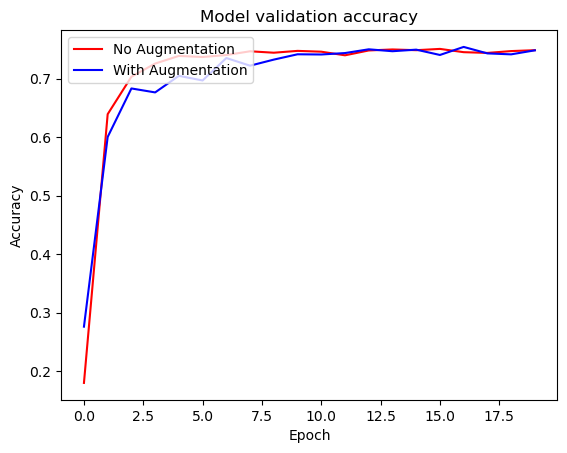

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

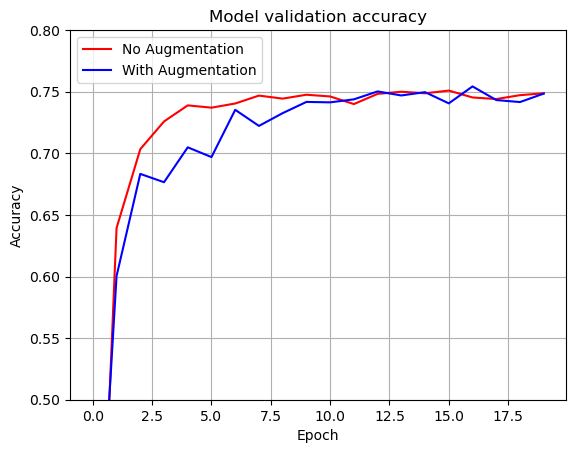

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

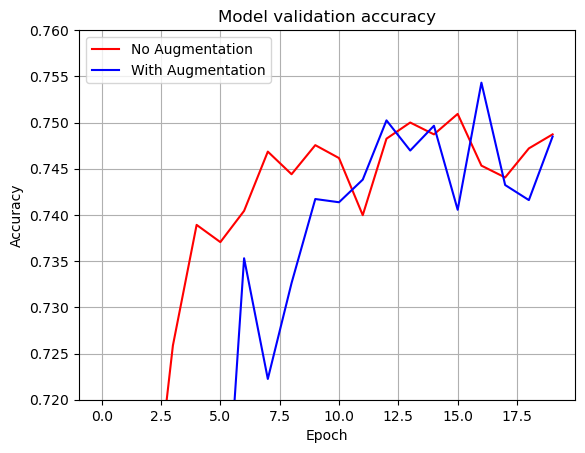

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

---
---
---

---
### Cutmix Augmentation

###### 이미지 섞기

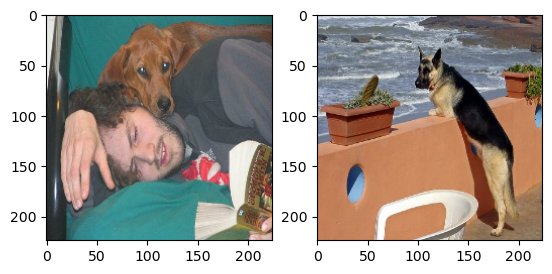

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(187, shape=(), dtype=int32)
y :  tf.Tensor(163, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


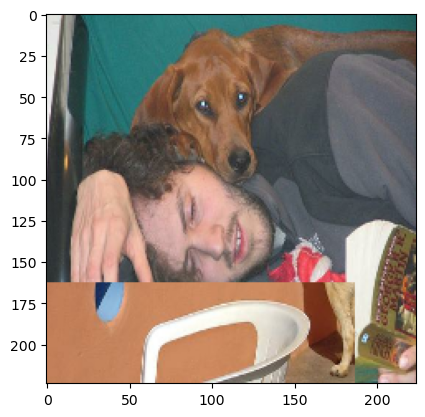

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

###### 라벨 섞기

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.77266026, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


---
### Mixup Augmentation

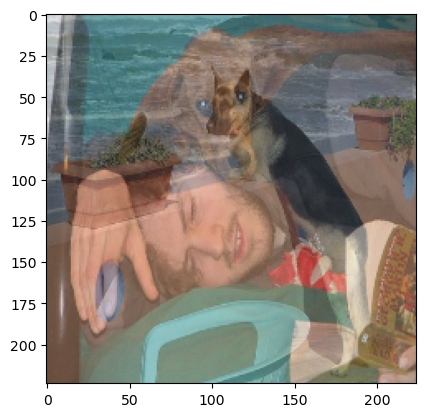

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.56525826
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.43474174 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

---
### CutMix 또는 Mixup 비교실험 하기

---

### preProcessing & Augmentation

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, ds_name, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    print('---',ds_name,'---')
    
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        print('111')
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        print('222')
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        print('333')
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        print('444')
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        print('555')
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

---
### stanford_dogs 데이터셋 또 다시 로딩
tensorflow_datasets.load

In [ ]:
(ds_train_2, ds_test_2), ds_info_2 = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,     # a 2-tuple structure (input, label)
    shuffle_files=True,
    with_info=True,
)

In [ ]:
ds_train_no_aug_oh = apply_normalize_on_dataset(ds_train_2, 'ds_train_no_aug_oh', with_aug=False)
ds_train_aug_oh = apply_normalize_on_dataset(ds_train_2, 'ds_train_aug_oh', with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train_2, 'ds_train_cutmix', with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train_2, 'ds_train_mixup', with_mixup=True)
ds_test_oh = apply_normalize_on_dataset(ds_test_2, 'ds_test_oh', is_test=True)

--- ds_train_no_aug_oh ---
444
555
--- ds_train_aug_oh ---
111
444
555
--- ds_train_cutmix ---
222
555
--- ds_train_mixup ---
333
555
--- ds_test_oh ---
444


In [ ]:
ds_train_no_aug_oh

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [ ]:
ds_train_aug_oh

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

In [ ]:
ds_train_cutmix

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [ ]:
ds_train_mixup

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [ ]:
ds_test_2

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
ds_test_oh

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

#### ResNet_50 모델을 4개 만든다.
* no_aug_resnet50_2
* aug_resnet50_2
* cutmix_resnet50
* mixup_resnet50

In [ ]:
# (model) no_aug_resnet50_2
no_aug_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# (model) aug_resnet50_2
aug_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# (model) cutmix_resnet50
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# (model) mixup_resnet50
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
tf.random.set_seed(22)

no_aug_resnet50_2.compile(
    loss='categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

aug_resnet50_2.compile(
    loss='categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    # optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

### Train
* ds_train_cutmix → cutmix_resnet50  → history_resnet50_cutmix
* ds_train_mixup  → mixup_resnet50   → history_resnet50_mixup

In [ ]:
history_resnet50_no_aug_2 = no_aug_resnet50_2.fit(
    ds_train_no_aug_oh,
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 186s 239ms/step - loss: 2.2119 - accuracy: 0.4442 - val_loss: 3.6188 - val_accuracy: 0.1728
Epoch 2/20
750/750 [==============================] - 178s 238ms/step - loss: 0.7730 - accuracy: 0.7850 - val_loss: 1.0821 - val_accuracy: 0.6811
Epoch 3/20
750/750 [==============================] - 178s 238ms/step - loss: 0.3201 - accuracy: 0.9219 - val_loss: 1.0426 - val_accuracy: 0.6961
Epoch 4/20
750/750 [==============================] - 178s 237ms/step - loss: 0.1116 - accuracy: 0.9842 - val_loss: 0.9292 - val_accuracy: 0.7327
Epoch 5/20
750/750 [==============================] - 178s 237ms/step - loss: 0.0467 - accuracy: 0.9962 - val_loss: 0.8998 - val_accuracy: 0.7425
Epoch 6/20
750/750 [==============================] - 178s 237ms/step - loss: 0.0312 - accuracy: 0.9979 - val_loss: 0.9037 - val_accuracy: 0.7442
Epoch 7/20
750/750 [==============================] - 178s 237ms/step - loss: 0.0192 - accuracy: 0.9983 - val_loss: 0.9114 -

In [ ]:
history_resnet50_aug_2 = aug_resnet50_2.fit(
    ds_train_aug_oh,    # Augmentation
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 187s 239ms/step - loss: 2.2955 - accuracy: 0.4218 - val_loss: 2.9504 - val_accuracy: 0.2755
Epoch 2/20
750/750 [==============================] - 178s 238ms/step - loss: 0.9920 - accuracy: 0.7064 - val_loss: 1.2781 - val_accuracy: 0.6357
Epoch 3/20
750/750 [==============================] - 178s 238ms/step - loss: 0.5923 - accuracy: 0.8324 - val_loss: 1.1245 - val_accuracy: 0.6754
Epoch 4/20
750/750 [==============================] - 178s 238ms/step - loss: 0.3570 - accuracy: 0.9076 - val_loss: 1.0439 - val_accuracy: 0.7021
Epoch 5/20
750/750 [==============================] - 178s 238ms/step - loss: 0.2267 - accuracy: 0.9427 - val_loss: 0.9403 - val_accuracy: 0.7329
Epoch 6/20
750/750 [==============================] - 178s 238ms/step - loss: 0.1403 - accuracy: 0.9693 - val_loss: 1.1191 - val_accuracy: 0.6905
Epoch 7/20
750/750 [==============================] - 178s 238ms/step - loss: 0.0946 - accuracy: 0.9833 - val_loss: 0.9659 -

In [ ]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,    # CUTMIX Augmentation
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 189s 242ms/step - loss: 3.8191 - accuracy: 0.2118 - val_loss: 3.1643 - val_accuracy: 0.2318
Epoch 2/20
750/750 [==============================] - 180s 240ms/step - loss: 2.9441 - accuracy: 0.4333 - val_loss: 1.5164 - val_accuracy: 0.5836
Epoch 3/20
750/750 [==============================] - 180s 240ms/step - loss: 2.6680 - accuracy: 0.5221 - val_loss: 1.2165 - val_accuracy: 0.6603
Epoch 4/20
750/750 [==============================] - 180s 240ms/step - loss: 2.4494 - accuracy: 0.5922 - val_loss: 1.2568 - val_accuracy: 0.6554
Epoch 5/20
750/750 [==============================] - 179s 239ms/step - loss: 2.3241 - accuracy: 0.6310 - val_loss: 1.3204 - val_accuracy: 0.6449
Epoch 6/20
750/750 [==============================] - 180s 240ms/step - loss: 2.2090 - accuracy: 0.6622 - val_loss: 1.1400 - val_accuracy: 0.6862
Epoch 7/20
750/750 [==============================] - 180s 240ms/step - loss: 2.1070 - accuracy: 0.6956 - val_loss: 1.3476 -

In [ ]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,     # MIXUP Augmentation
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 189s 243ms/step - loss: 3.7322 - accuracy: 0.2376 - val_loss: 4.3101 - val_accuracy: 0.0885
Epoch 2/20
750/750 [==============================] - 180s 241ms/step - loss: 2.8707 - accuracy: 0.4767 - val_loss: 1.5492 - val_accuracy: 0.5813
Epoch 3/20
750/750 [==============================] - 180s 241ms/step - loss: 2.5998 - accuracy: 0.5772 - val_loss: 1.3821 - val_accuracy: 0.6096
Epoch 4/20
750/750 [==============================] - 181s 241ms/step - loss: 2.4308 - accuracy: 0.6384 - val_loss: 1.3235 - val_accuracy: 0.6375
Epoch 5/20
750/750 [==============================] - 180s 241ms/step - loss: 2.2976 - accuracy: 0.6925 - val_loss: 1.2933 - val_accuracy: 0.6454
Epoch 6/20
750/750 [==============================] - 181s 241ms/step - loss: 2.2107 - accuracy: 0.7257 - val_loss: 1.2561 - val_accuracy: 0.6564
Epoch 7/20
750/750 [==============================] - 180s 241ms/step - loss: 2.1157 - accuracy: 0.7562 - val_loss: 1.2655 -

### 성능 평가

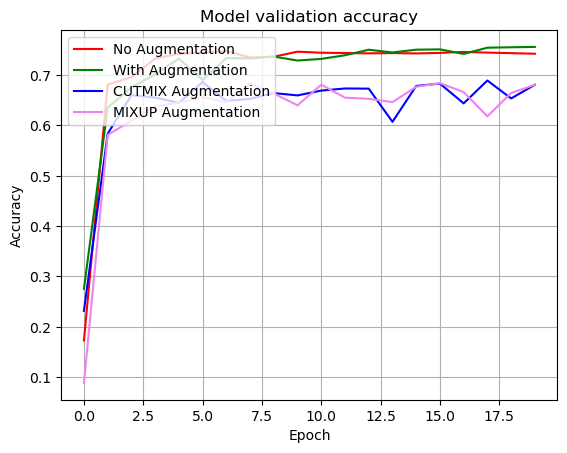

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

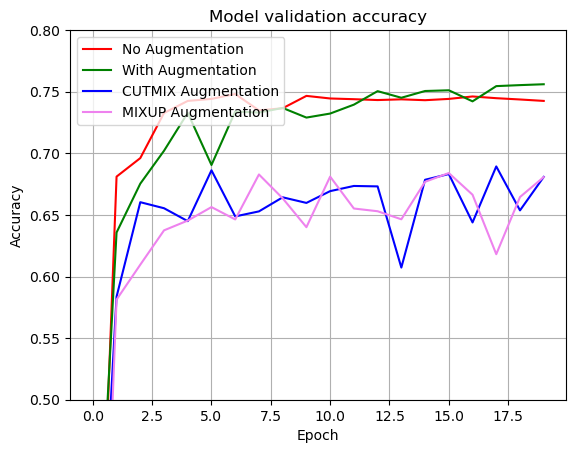

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

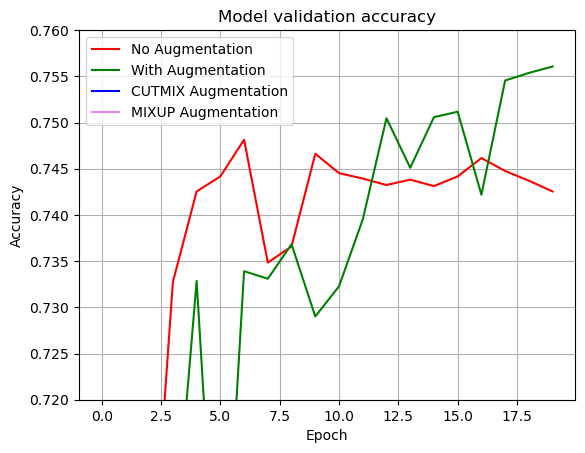

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

---
기본 Augmentation 하여 훈련한 aug_resnet50_2 모델에,<br>
ds_train_cutmix 로 다시 훈련한다.

In [ ]:
# 기본 Augmentation + Cutmix
history_resnet50_aug_plus_cutmix = aug_resnet50_2.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 184s 237ms/step - loss: 2.3850 - accuracy: 0.6461 - val_loss: 1.2403 - val_accuracy: 0.6735
Epoch 2/20
750/750 [==============================] - 180s 240ms/step - loss: 2.1872 - accuracy: 0.6941 - val_loss: 1.3261 - val_accuracy: 0.6521
Epoch 3/20
750/750 [==============================] - 180s 240ms/step - loss: 2.0975 - accuracy: 0.7141 - val_loss: 1.3203 - val_accuracy: 0.6610
Epoch 4/20
750/750 [==============================] - 180s 240ms/step - loss: 2.0047 - accuracy: 0.7338 - val_loss: 1.2029 - val_accuracy: 0.6896
Epoch 5/20
750/750 [==============================] - 180s 240ms/step - loss: 1.9528 - accuracy: 0.7487 - val_loss: 1.3886 - val_accuracy: 0.6456
Epoch 6/20
750/750 [==============================] - 180s 240ms/step - loss: 1.9089 - accuracy: 0.7561 - val_loss: 1.2526 - val_accuracy: 0.6802
Epoch 7/20
750/750 [==============================] - 180s 240ms/step - loss: 1.8636 - accuracy: 0.7648 - val_loss: 1.2724 -

#####(노란색)<br>
기본 Augmentation에, Cutmix한 데이터셋으로 다시 학습시켰으나, 별다른 개선이 보여지지 않는다.

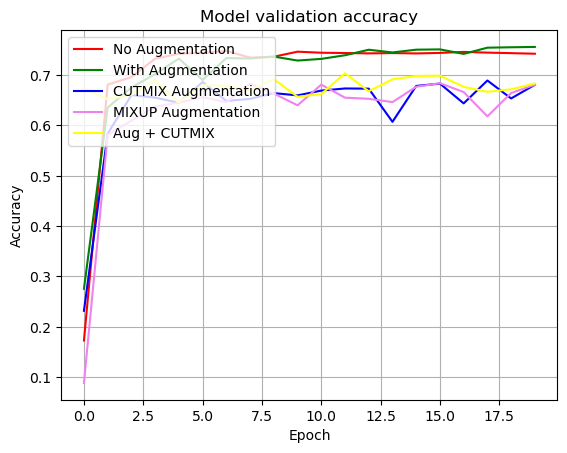

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.plot(history_resnet50_aug_plus_cutmix.history['val_accuracy'], color='yellow')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation', 'Aug + CUTMIX'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

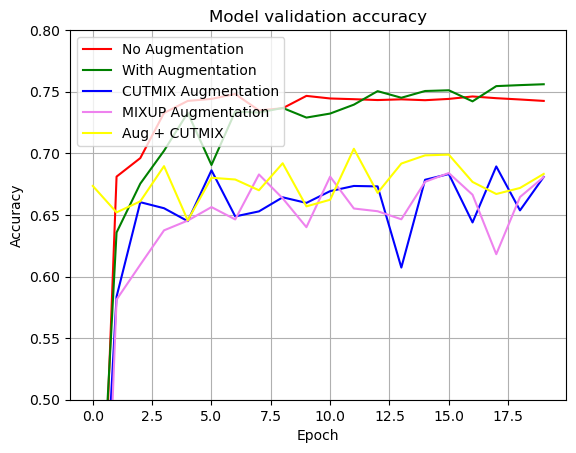

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.plot(history_resnet50_aug_plus_cutmix.history['val_accuracy'], color='yellow')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation', 'Aug + CUTMIX'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.plot(history_resnet50_aug_plus_cutmix.history['val_accuracy'], color='yellow')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation', 'Aug + CUTMIX'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

---
기본 Augementation 을 학습한 모델에,<br>
Cutmix 데이터셋을 학습시키고,<br>
다시 Mixup 데이터셋으로 학습시킨다.<br>

In [ ]:
# 기본 Augmentation + Cutmix + Mixup
history_resnet50_aug_cutmix = aug_resnet50_2.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 181s 239ms/step - loss: 1.8818 - accuracy: 0.8367 - val_loss: 1.5273 - val_accuracy: 0.6549
Epoch 2/20
750/750 [==============================] - 181s 241ms/step - loss: 1.8197 - accuracy: 0.8460 - val_loss: 1.6503 - val_accuracy: 0.6269
Epoch 3/20
750/750 [==============================] - 181s 241ms/step - loss: 1.7967 - accuracy: 0.8539 - val_loss: 1.3763 - val_accuracy: 0.6832
Epoch 4/20
750/750 [==============================] - 181s 242ms/step - loss: 1.7635 - accuracy: 0.8561 - val_loss: 1.4604 - val_accuracy: 0.6732
Epoch 5/20
750/750 [==============================] - 181s 242ms/step - loss: 1.7367 - accuracy: 0.8593 - val_loss: 1.5276 - val_accuracy: 0.6559
Epoch 6/20
750/750 [==============================] - 181s 241ms/step - loss: 1.7260 - accuracy: 0.8634 - val_loss: 1.4624 - val_accuracy: 0.6704
Epoch 7/20
750/750 [==============================] - 181s 242ms/step - loss: 1.7037 - accuracy: 0.8622 - val_loss: 1.4885 -

#### (검정색)<br>
기본 Augemntation + Cutmix + Mixup 데이터셋으로 학습시켰지만,<br>
별다른 개선이 없다.

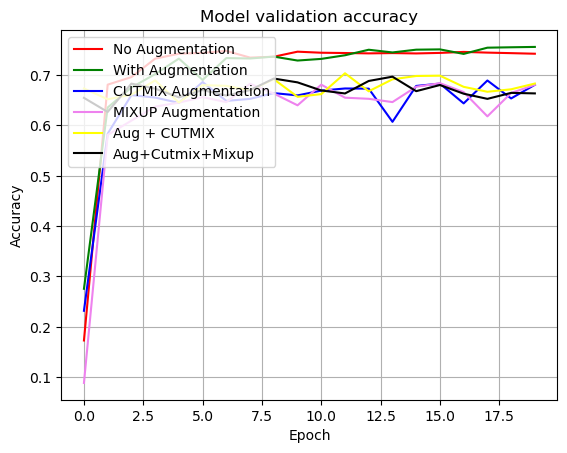

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.plot(history_resnet50_aug_plus_cutmix.history['val_accuracy'], color='yellow')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], color='black') # 이름을 잘못 적고 돌렸으나, aug+Cutmix+Mixup임.
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation', 'Aug + CUTMIX', 'Aug+Cutmix+Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

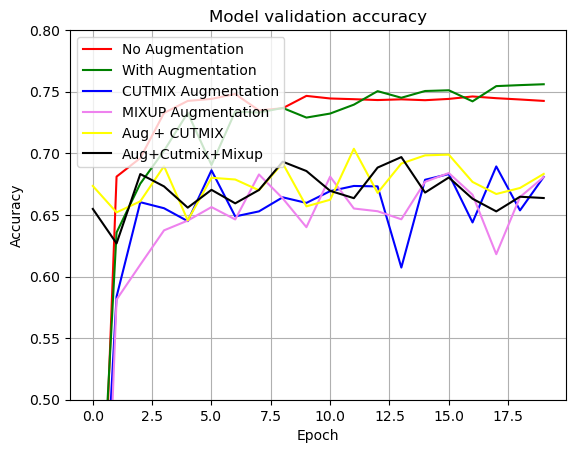

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.plot(history_resnet50_aug_plus_cutmix.history['val_accuracy'], color='yellow')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], color='black') # 이름을 잘못 적고 돌렸으나, aug+Cutmix+Mixup임.
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation', 'Aug + CUTMIX', 'Aug+Cutmix+Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

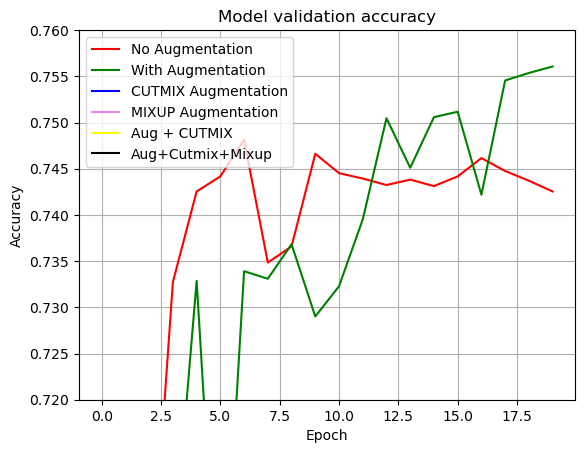

In [ ]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.plot(history_resnet50_aug_plus_cutmix.history['val_accuracy'], color='yellow')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], color='black') # 이름을 잘못 적고 돌렸으나, aug+Cutmix+Mixup임.
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation', 'Aug + CUTMIX', 'Aug+Cutmix+Mixup'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### 회고

처음은 노드에서 나오는대로,<br>
 Augmentation을 하지 않은 것과, 약간의 Augmentation을 한 것을 비교하였다.<br>
결과는 기본적인 Augmentation을 한 것이 살짝 좋은 편이었다.<br>
<br>
다음으로, Cutmix 와 Mixup 으로 Augumentation을 하였는데,<br>
예상 외로, Augumentation 하지 않은 것 보다도 Accuracy가 낮았다.<br>
<br>
이유를 생각하다가 그럴 수도 있겠다는 생각이 들었다.<br>
<br>
Augmentation을 하는 이유는,<br>
부족한 데이터로 인해, 기존의 데이터를 활용하여 다양성을 학습시키는 것이<br>
아닐까 생각되는데, 그렇다면 Cutmix나 Mixup 단독으로 돌려서는 의미가 없고,<br>
추가적인 학습에 사용하는 것이 의미가 있다고 추측하였다.<br>
<br>
그래서,<br>
우선, 약간의 Augmentation을 한 aug_resnet50_2 모델을 대상으로,<br>
ds_train_cutmix를 돌렸다. (yellow)<br>
그러나, Accuracy는 큰 개선이 없었다.<br>
<br>
그래서, 다시, <br>
aug_resnet50_2 모델을 대상으로, ds_train_mixup 을 돌렸다. (black)<br>
<br>
장시간 시행착오와 반복을 거치며 실험을 했던 이유는,<br>
기본 Augmentation 으로 학습하고, Cutmix 와 Mixup 데이터셋으로 학습하면,<br>
원본 이미지만으로 학습했던 모델의 성능을 월등히 상회하는 결과를 기대했었기 때문이었다.<br>
<br>
하지만, 기본 Augmentation에, Cutmix 와 Mixup 까지 학습한 모델이<br>
원본 이미지만 학습한 경우 보다, 성능이 떨어져서 아쉬웠고,<br>
Augmentation을 거쳐서 성능이 좋아지는 케이스를 경험하지 못하게 되어,<br>
아쉽게 생각합니다.